#Installing Necessary Packages and Mounting Gdrive


In [ ]:
import os
import pandas as pd
import librosa

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Mount GDrive

from google.colab import drive

try:
    drive.mount('/content/gdrive/')
except:
    drive.mount("/content/gdrive/", force_remount=True)
    print('drive mounted')

# Define the root path
rootpath = '/content/gdrive/My Drive/Capstone Project ML'

# Change the current working directory to the root path
os.chdir(rootpath)

Ravdess = 'ravdess'

Crema = 'Crema-D'


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Loading data
Datasets and features already loaded from prior code, all this is loading from csv files

In [ ]:
# Load the datasets
chroma_df = pd.read_csv('chroma_features_df.csv')
zero_crossing_rates_df = pd.read_csv('zero_crossing_rates_df.csv')
fccs_df = pd.read_csv('MFCCs_df.csv')
pitch_df = pd.read_csv('pitch_features.csv')

# Make sure 'Unnamed: 0' is an index column in your DataFrames
chroma_df.set_index('Unnamed: 0', inplace=True)
zero_crossing_rates_df.set_index('Unnamed: 0', inplace=True)
fccs_df.set_index('Unnamed: 0', inplace=True)
pitch_df.set_index('Unnamed: 0', inplace=True)

# If 'Emotion' column is in all DataFrames and they are in the same order, you can drop the extra 'Emotion' columns
# Keep only the 'Emotion' column from the first DataFrame (chroma_df)
zero_crossing_rates_df.drop('Emotion', axis=1, inplace=True)
fccs_df.drop('Emotion', axis=1, inplace=True)
pitch_df.drop('Emotion', axis=1, inplace=True)

# Merge the dataframes on the index which is now 'Unnamed: 0'
merged_df = chroma_df.merge(zero_crossing_rates_df, left_index=True, right_index=True)
merged_df = merged_df.merge(fccs_df, left_index=True, right_index=True)
merged_df = merged_df.merge(pitch_df, left_index=True, right_index=True)

# Check the first few rows of the merged dataframe to ensure it's all correct
print(merged_df.head())

# Optionally, save the merged dataframe to a new CSV file
merged_df.to_csv('merged_features_with_pitch.csv', index=False)

# Drop rows with any NaN values
merged_df_cleaned_all = merged_df.dropna()

# Keep only angry, happy, sad, neutral
filter = merged_df_cleaned_all['Emotion'].isin(['angry', 'sad', 'neutral'])
merged_df_cleaned = merged_df_cleaned_all[filter]


# Compare before and after removing null values
print("Before cleaning:", merged_df.shape)
print("After cleaning:", merged_df_cleaned.shape)

            Emotion  Chroma_1  Chroma_2  Chroma_3  Chroma_4  Chroma_5  \
Unnamed: 0                                                              
0              fear  0.222484  0.283602  0.304918  0.276355  0.306326   
1             angry  0.244303  0.218833  0.195134  0.257927  0.418566   
2             happy  0.343111  0.215817  0.179809  0.193326  0.253426   
3           neutral  0.232486  0.318446  0.274485  0.264600  0.397363   
4           disgust  0.302813  0.252577  0.225068  0.237080  0.267770   

            Chroma_6  Chroma_7  Chroma_8  Chroma_9  ...     MFCC_5     MFCC_6  \
Unnamed: 0                                          ...                         
0           0.356323  0.401789  0.349832  0.400864  ... -12.059236   8.862662   
1           0.371049  0.346892  0.374909  0.458341  ... -18.002378  13.929490   
2           0.354100  0.532238  0.457406  0.462393  ...  -4.272263  13.564652   
3           0.376181  0.376865  0.357119  0.500117  ... -11.827156  28.395706   
4 

In [ ]:
# Separate features and targets
X = merged_df_cleaned.drop('Emotion', axis=1)  # Assuming 'Emotion' is still in 'merged_df_cleaned'
y = merged_df_cleaned['Emotion']  # Target variable which is categorical

X_binary = merged_df_cleaned_all.drop('Emotion', axis=1) # For binary
# Using .loc[] to safely create and modify columns
merged_df_cleaned_all.loc[:, 'Emotion_Binary'] = (merged_df_cleaned_all['Emotion'] == 'angry').astype(int)
y_binary = merged_df_cleaned_all['Emotion_Binary']  # Binary target variable

# Encode the target variable
encoder_y = LabelEncoder()
y_encoded = encoder_y.fit_transform(y)
encoder_y_binary = LabelEncoder()
y_binary_encoded = encoder_y_binary.fit_transform(y_binary)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True)
x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary, y_binary_encoded, test_size=0.2, random_state=42, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
X_train_binary = scaler.fit_transform(x_train_binary)
X_test_binary = scaler.transform(x_test_binary)


<ipython-input-4-ab0261af1a77>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned_all.loc[:, 'Emotion_Binary'] = (merged_df_cleaned_all['Emotion'] == 'angry').astype(int)


# Random Forest

In [ ]:
def train_and_evaluate_RF(X_train, y_train, X_test, y_test):
  model = RandomForestClassifier(random_state=42)
  param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
  # Create the GridSearchCV object
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

  # Fit GridSearchCV
  grid_search.fit(X_train, y_train)
  best_RF = grid_search.best_estimator_
  y_pred = best_RF.predict(X_test)

  #Evaluation
  accuracy_RF = accuracy_score(y_test, y_pred)
  report_RF = classification_report(y_test, y_pred)
  confusion_RF = confusion_matrix(y_test, y_pred)

  return best_RF, accuracy_RF, report_RF, confusion_RF



## Random Forest for Angry, Neutral, and Sad

In [ ]:
best_RF_model, accuracy_RF, report_RF, confusion_RF = train_and_evaluate_RF(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


Best Random Forest Model after Grid Search: RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=300,
                       random_state=42)
Accuracy: 0.7755813953488372
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       304
           1       0.65      0.72      0.68       272
           2       0.76      0.71      0.73       284

    accuracy                           0.78       860
   macro avg       0.78      0.77      0.77       860
weighted avg       0.78      0.78      0.78       860

Confusion Matrix:


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

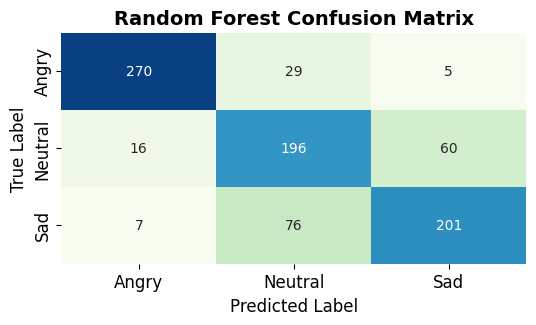

In [ ]:
# Print the evaluation results
print(f"Best Random Forest Model after Grid Search: {best_RF_model}")
print(f"Accuracy: {accuracy_RF}")
print("Classification Report:")
print(report_RF)
print("Confusion Matrix:")


plt.figure(figsize=(6, 3))
sns.heatmap(confusion_RF, annot=True, cmap='GnBu', fmt='d', cbar=False)
tick_labels = ['Angry', 'Neutral', 'Sad']
tick_positions = [0.5, 1.5, 2.5]  # Position ticks at the center of each label
plt.yticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xlabel('Predicted Label', fontfamily = 'sans-serif', fontsize=12)
plt.ylabel('True Label', fontfamily = 'sans-serif', fontsize=12)
plt.title('Random Forest Confusion Matrix', fontfamily = 'sans-serif', fontsize=14, fontweight='bold')

## Random Forest for Angry vs Not Angry

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest Model for Binary after Grid Search: RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=300,
                       random_state=42)
Accuracy: 0.8722669735327964
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1434
           1       0.70      0.48      0.57       304

    accuracy                           0.87      1738
   macro avg       0.80      0.72      0.75      1738
weighted avg       0.86      0.87      0.86      1738

Confusion Matrix:


Text(0.5, 1.0, 'Random Forest Binary Confusion Matrix')

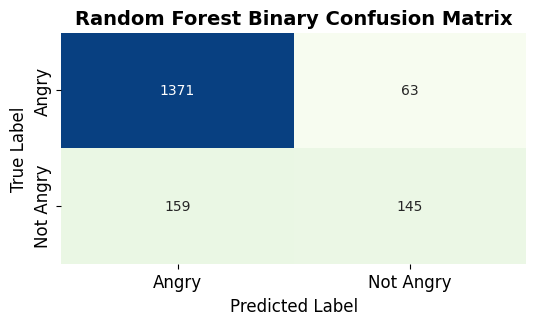

In [ ]:
best_RF_model_binary, accuracy_RF_binary, report_RF_binary, confusion_RF_binary = train_and_evaluate_RF(X_train_binary, y_train_binary, X_test_binary, y_test_binary)

# Print the evaluation results
print(f"Best Random Forest Model for Binary after Grid Search: {best_RF_model_binary}")
print(f"Accuracy: {accuracy_RF_binary}")
print("Classification Report:")
print(report_RF_binary)
print("Confusion Matrix:")


plt.figure(figsize=(6, 3))
sns.heatmap(confusion_RF_binary, annot=True, cmap='GnBu', fmt='d', cbar=False)
tick_labels = ['Angry', 'Not Angry']
tick_positions = [0.5, 1.5]  # Position ticks at the center of each label
plt.yticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xlabel('Predicted Label', fontfamily = 'sans-serif', fontsize=12)
plt.ylabel('True Label', fontfamily = 'sans-serif', fontsize=12)
plt.title('Random Forest Binary Confusion Matrix', fontfamily = 'sans-serif', fontsize=14, fontweight='bold')

# ExtraTrees Model

In [ ]:
# Create Function
def train_and_evaluate_ET(x_train, y_train, x_test, y_test):
    # Initialize ExtraTreesClassifier
    ET = ExtraTreesClassifier(random_state=42)

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=ET, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

    grid_search.fit(x_train, y_train)

    # Get the best estimator from grid search
    best_ET = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_ET.predict(x_test)
    #Evaluation
    accuracy_ET = accuracy_score(y_test, y_pred)
    report_ET = classification_report(y_test, y_pred)
    confusion_ET = confusion_matrix(y_test, y_pred)

    return best_ET, accuracy_ET, report_ET, confusion_ET


## ExtraTrees for Angry, Neutral, and Sad

In [ ]:
best_ET_model, accuracy_ET, report_ET, confusion_ET = train_and_evaluate_ET(x_train, y_train, x_test, y_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best Extra Trees Model after Grid Search: ExtraTreesClassifier(max_depth=20, random_state=42)
Accuracy: 0.7732558139534884
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       304
           1       0.66      0.69      0.68       272
           2       0.75      0.72      0.74       284

    accuracy                           0.77       860
   macro avg       0.77      0.77      0.77       860
weighted avg       0.77      0.77      0.77       860

Confusion Matrix:


Text(0.5, 1.0, 'Extra Trees Confusion Matrix')

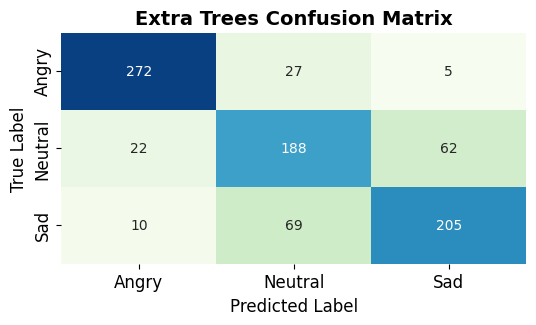

In [ ]:
# Print the evaluation results
print(f"Best Extra Trees Model after Grid Search: {best_ET_model}")
print(f"Accuracy: {accuracy_ET}")
print("Classification Report:")
print(report_ET)
print("Confusion Matrix:")

plt.figure(figsize=(6, 3))
sns.heatmap(confusion_ET, annot=True, cmap='GnBu', fmt='d', cbar=False)
tick_labels = ['Angry', 'Neutral', 'Sad']
tick_positions = [0.5, 1.5, 2.5]  # Position ticks at the center of each label
plt.yticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xlabel('Predicted Label', fontfamily = 'sans-serif', fontsize=12)
plt.ylabel('True Label', fontfamily = 'sans-serif', fontsize=12)
plt.title('Extra Trees Confusion Matrix', fontfamily = 'sans-serif', fontsize=14, fontweight='bold')


## ExtraTrees for Angry vs Not Angry

In [ ]:
binary_ET_model, accuracy_ET_binary, report_ET_binary, confusion_ET_binary = train_and_evaluate_ET(x_train_binary, y_train_binary, x_test_binary, y_test_binary)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best Binary Extra Tree Model after Grid Search: ExtraTreesClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42)
Accuracy: 0.8711162255466053
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      1434
           1       0.72      0.43      0.54       304

    accuracy                           0.87      1738
   macro avg       0.80      0.70      0.73      1738
weighted avg       0.86      0.87      0.86      1738

Confusion Matrix:


Text(0.5, 1.0, 'Extra Trees Confusion Matrix')

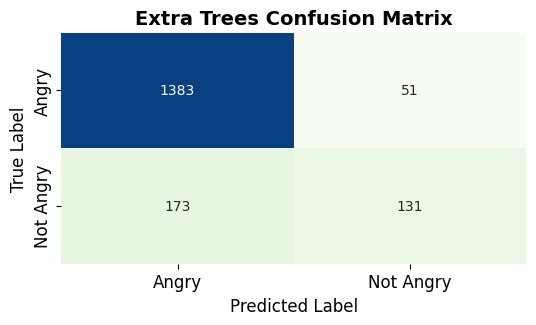

In [ ]:
# Print the evaluation results
print(f"Best Binary Extra Tree Model after Grid Search: {binary_ET_model}")
print(f"Accuracy: {accuracy_ET_binary}")
print("Classification Report:")
print(report_ET_binary)
print("Confusion Matrix:")

plt.figure(figsize=(6, 3))
sns.heatmap(confusion_ET_binary, annot=True, cmap='GnBu', fmt='d', cbar=False)
tick_labels = ['Angry', 'Not Angry']
tick_positions = [0.5, 1.5]  # Position ticks at the center of each label
plt.yticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xlabel('Predicted Label', fontfamily = 'sans-serif', fontsize=12)
plt.ylabel('True Label', fontfamily = 'sans-serif', fontsize=12)
plt.title('Extra Trees Confusion Matrix', fontfamily = 'sans-serif', fontsize=14, fontweight='bold')

# Gradient Boost Model

In [ ]:
def train_and_evaluate_gbm(x_train, y_train, x_test, y_test):
    # Initialize the Gradient Boosting Classifier
    gbm = GradientBoostingClassifier(random_state=42)

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [50, 100, 150],  # Number of boosting stages
        'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
        'max_depth': [3, 4, 5]  # Maximum depth of the individual trees
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

    # Train the model with grid search
    grid_search.fit(x_train, y_train)

    # Get the best estimator from grid search
    best_gbm = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_gbm.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    return best_gbm, accuracy, report, confusion



## Gradient Boost for Angry, Neutral, and Sad

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Gradient Boost Model after Grid Search: GradientBoostingClassifier(max_depth=4, random_state=42)
Accuracy: 0.763953488372093
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       304
           1       0.63      0.71      0.67       272
           2       0.74      0.70      0.72       284

    accuracy                           0.76       860
   macro avg       0.77      0.76      0.76       860
weighted avg       0.77      0.76      0.77       860

Confusion Matrix:


Text(0.5, 1.0, 'Gradient Boost Confusion Matrix')

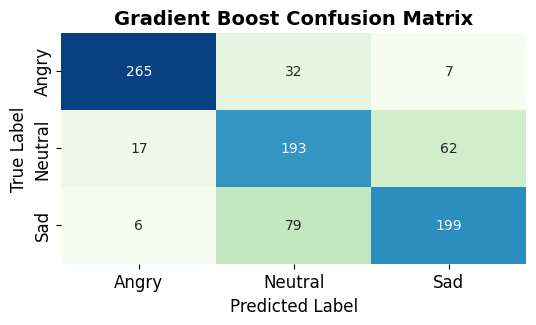

In [ ]:
best_gbm_model, accuracy_gb, report_gb, confusion_gb = train_and_evaluate_gbm(x_train, y_train, x_test, y_test)
# Print the evaluation results
print(f"Best Gradient Boost Model after Grid Search: {best_gbm_model}")
print(f"Accuracy: {accuracy_gb}")
print("Classification Report:")
print(report_gb)
print("Confusion Matrix:")

plt.figure(figsize=(6, 3))
sns.heatmap(confusion_gb, annot=True, cmap='GnBu', fmt='d', cbar=False)
tick_labels = ['Angry', 'Neutral', 'Sad']
tick_positions = [0.5, 1.5, 2.5]  # Position ticks at the center of each label
plt.yticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xlabel('Predicted Label', fontfamily = 'sans-serif', fontsize=12)
plt.ylabel('True Label', fontfamily = 'sans-serif', fontsize=12)
plt.title('Gradient Boost Confusion Matrix', fontfamily = 'sans-serif', fontsize=14, fontweight='bold')

## Gradient Boost for Angry vs Not Angry

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Binary Gradient Boost Model after Grid Search: GradientBoostingClassifier(max_depth=5, n_estimators=150, random_state=42)
Accuracy: 0.8814729574223246
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1434
           1       0.71      0.54      0.61       304

    accuracy                           0.88      1738
   macro avg       0.81      0.75      0.77      1738
weighted avg       0.87      0.88      0.87      1738

Confusion Matrix:


Text(0.5, 1.0, 'Gradient Boost Confusion Matrix')

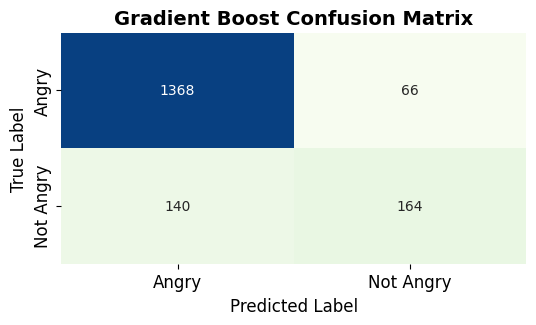

In [ ]:
binary_gbm_model, accuracy_gb_binary, report_gb_binary, confusion_gb_binary = train_and_evaluate_gbm(X_train_binary, y_train_binary, X_test_binary, y_test_binary)
# Print the evaluation results
print(f"Best Binary Gradient Boost Model after Grid Search: {binary_gbm_model}")
print(f"Accuracy: {accuracy_gb_binary}")
print("Classification Report:")
print(report_gb_binary)
print("Confusion Matrix:")

plt.figure(figsize=(6, 3))
sns.heatmap(confusion_gb_binary, annot=True, cmap='GnBu', fmt='d', cbar=False)
tick_labels = ['Angry', 'Not Angry']
tick_positions = [0.5, 1.5]  # Position ticks at the center of each label
plt.yticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xlabel('Predicted Label', fontfamily = 'sans-serif', fontsize=12)
plt.ylabel('True Label', fontfamily = 'sans-serif', fontsize=12)
plt.title('Gradient Boost Confusion Matrix', fontfamily = 'sans-serif', fontsize=14, fontweight='bold')

# SVC Model

In [ ]:
# Create Function
def train_and_evaluate_svm_with_grid_search(x_train, y_train, x_test, y_test):
    # Define the parameter grid to search
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
        'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' and 'poly'
    }

    # Initialize the Support Vector Classifier
    svm = SVC(random_state=42, probability = True) # Enable probability estimates

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

    # Train the model with grid search
    grid_search.fit(x_train, y_train)

    # Get the best estimator from grid search
    best_svm = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_svm.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    return best_svm, accuracy, report, confusion



## SVC for Angry, Neutral, and Sad

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best SVC Model after Grid Search: SVC(C=1, probability=True, random_state=42)
Accuracy: 0.7662790697674419
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       304
           1       0.64      0.70      0.67       272
           2       0.73      0.71      0.72       284

    accuracy                           0.77       860
   macro avg       0.77      0.76      0.76       860
weighted avg       0.77      0.77      0.77       860

Confusion Matrix:


Text(0.5, 1.0, 'SVC Confusion Matrix')

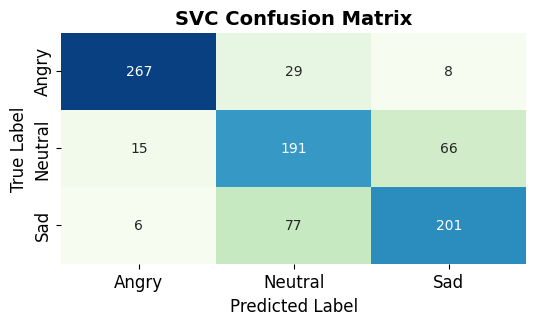

In [ ]:
svm_model, accuracy_svc, report_svc, confusion_svc = train_and_evaluate_svm_with_grid_search(X_train, y_train, X_test, y_test)
# Print the evaluation results
print(f"Best SVC Model after Grid Search: {svm_model}")
print(f"Accuracy: {accuracy_svc}")
print("Classification Report:")
print(report_svc)
print("Confusion Matrix:")

plt.figure(figsize=(6, 3))
sns.heatmap(confusion_svc, annot=True, cmap='GnBu', fmt='d', cbar=False)
tick_labels = ['Angry', 'Neutral', 'Sad']
tick_positions = [0.5, 1.5, 2.5]  # Position ticks at the center of each label
plt.yticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xlabel('Predicted Label', fontfamily = 'sans-serif', fontsize=12)
plt.ylabel('True Label', fontfamily = 'sans-serif', fontsize=12)
plt.title('SVC Confusion Matrix', fontfamily = 'sans-serif', fontsize=14, fontweight='bold')

## SVC for Angry vs Not Angry

In [ ]:
svm_model_binary, accuracy_svc_binary, report_svc_binary, confusion_svc_binary = train_and_evaluate_svm_with_grid_search(X_train_binary, y_train_binary, X_test_binary, y_test_binary)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


Best SVC Model for Binary Emotions after Grid Search: SVC(C=1, probability=True, random_state=42)
Accuracy: 0.880897583429229
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1434
           1       0.75      0.48      0.59       304

    accuracy                           0.88      1738
   macro avg       0.82      0.72      0.76      1738
weighted avg       0.87      0.88      0.87      1738

Confusion Matrix:


Text(0.5, 1.0, 'SVC Confusion Matrix for Binary')

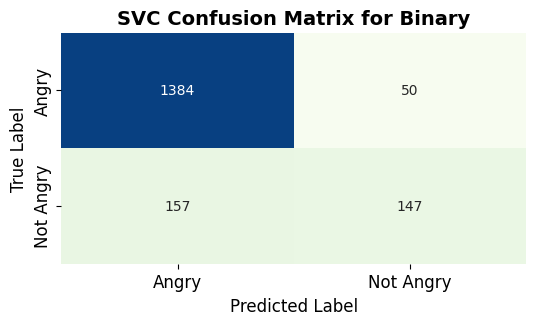

In [ ]:
# Print the evaluation results
print(f"Best SVC Model for Binary Emotions after Grid Search: {svm_model_binary}")
print(f"Accuracy: {accuracy_svc_binary}")
print("Classification Report:")
print(report_svc_binary)
print("Confusion Matrix:")

plt.figure(figsize=(6, 3))
sns.heatmap(confusion_svc_binary, annot=True, cmap='GnBu', fmt='d', cbar=False)
tick_labels = ['Angry', 'Not Angry']
tick_positions = [0.5, 1.5]  # Position ticks at the center of each label
plt.yticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xticks(tick_positions, tick_labels, fontfamily = 'sans-serif', fontsize=12)
plt.xlabel('Predicted Label', fontfamily = 'sans-serif', fontsize=12)
plt.ylabel('True Label', fontfamily = 'sans-serif', fontsize=12)
plt.title('SVC Confusion Matrix for Binary', fontfamily = 'sans-serif', fontsize=14, fontweight='bold')

# Comparing Accuracies

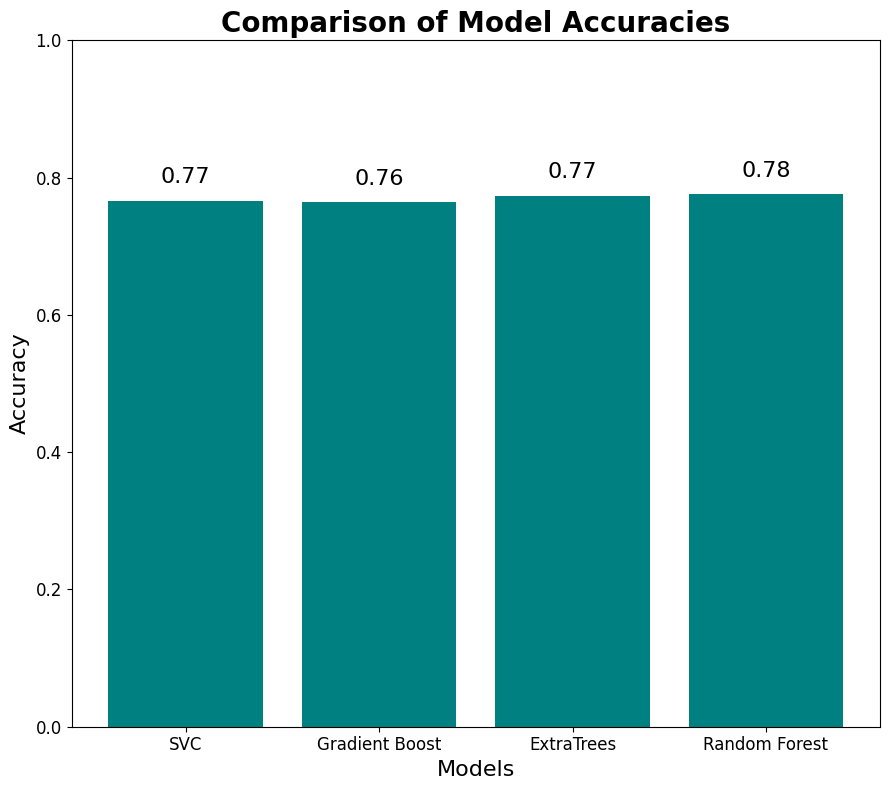

In [ ]:
# 3 Emotions
# Create a bar plot for accuracy and precision
models = ['SVC', 'Gradient Boost', 'ExtraTrees', 'Random Forest']
accuracies = [accuracy_svc, accuracy_gb, accuracy_ET, accuracy_RF]

# Create a bar plot for model accuracies
plt.figure(figsize=(9, 8))
plt.bar(models, accuracies, color = 'teal')
plt.xlabel('Models', fontfamily = 'sans-serif', fontsize=16)
plt.ylabel('Accuracy', fontfamily = 'sans-serif', fontsize=16)
plt.title('Comparison of Model Accuracies', fontsize = 20, fontweight='bold')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy scores
plt.xticks(fontfamily = 'sans-serif', fontsize=12)
plt.yticks(fontfamily = 'sans-serif', fontsize=12)

# Add text annotations for each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontfamily = 'sans-serif', fontsize=16)


plt.tight_layout()
plt.show()


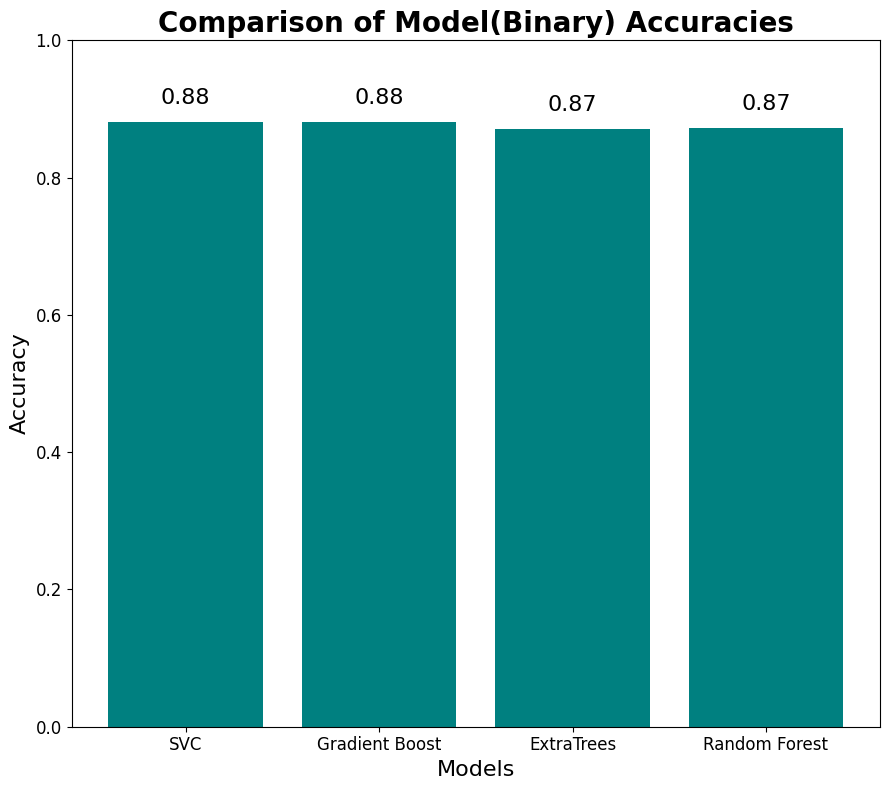

In [ ]:
# Angry vs Not Angry
# Create a bar plot for accuracy and precision
models = ['SVC', 'Gradient Boost', 'ExtraTrees', 'Random Forest']
accuracies = [accuracy_svc_binary, accuracy_gb_binary, accuracy_ET_binary, accuracy_RF_binary]

# Create a bar plot for model accuracies
plt.figure(figsize=(9, 8))
plt.bar(models, accuracies, color = 'teal')
plt.xlabel('Models', fontfamily = 'sans-serif', fontsize=16)
plt.ylabel('Accuracy', fontfamily = 'sans-serif', fontsize=16)
plt.title('Comparison of Model(Binary) Accuracies', fontsize = 20, fontweight='bold')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy scores
plt.xticks(fontfamily = 'sans-serif', fontsize=12)
plt.yticks(fontfamily = 'sans-serif', fontsize=12)

# Add text annotations for each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontfamily = 'sans-serif', fontsize=16)


plt.tight_layout()
plt.show()
